# Identify Koopman Eigenfunctions of the Hamiltonian of a Simple Pendulum using Sparse Identification of Nonlinear Dynamical systems (SINDy)
This notebook gives an overview of the Sparse Identification of Nonlinear Dynamical systems (SINDy) method and discusses the relationship between SINDy and PySINDy. It also includes a brief example showing how different objects in the SINDy method are represented in PySINDy.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7?filepath=examples/2_introduction_to_sindy.ipynb)

## Main ideas
Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$ 
	\frac{d}{dt}x = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## Approximation problem
To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then 

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

## Structure of PySINDy
The submodules of PySINDy are each aligned with one of the terms in the aforementioned approximation equation

$$ \dot X \approx \Theta(X)\Xi. $$

 * `pysindy.differentiate` performs numerical differentiation to compute $\dot X$ from $X$;
 * `pysindy.feature_library` allows the user to specify a set of library functions and handles the formation of $\Theta(X)$;
 * `pysindy.optimizers` provides a set of sparse regression solvers for determining $\Xi$.

The `SINDy` object encapsulates one class object from each of these three submodules and uses them, along with a user-supplied data matrix, to find a governing dynamical system.


In [52]:
import numpy as np
import PySINDY.pysindy as ps
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## System model
Suppose we have measurements of the of a simple pendulum obeying the following dynamical system at different points in time:

$$
	\frac{d}{dt} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
	= \begin{bmatrix} x_2 \\ -sin(x_1) \end{bmatrix}
$$

In [53]:
def simple_pendulum(x, t):
    return [x[1], -np.sin(x[0])]

In [54]:
dt = 0.01
t_train = np.arange(0, 150, dt)
x0_train = [1, 0]
x_train = odeint(simple_pendulum, x0_train, t_train)
#x_dot_train = np.array([simple_pendulum(xi, 1) for xi in x_train])

[Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Training data (Pendulum system)')]

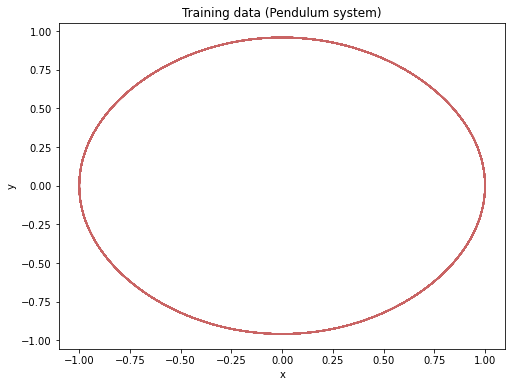

In [55]:
# Plot training data
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_train[:, 0], x_train[:, 1], color="firebrick", alpha=0.7)
ax.set(xlabel="x", ylabel="y", title="Training data (Pendulum system)")

We can select a differentiation method from the `differentiation` submodule.

In [56]:
differentiation_method = ps.FiniteDifference(order=2)

# We could instead call ps.differentiation.FiniteDifference(order=2)

While we could use this method to compute $\dot X$ "by hand," it is often more convenient to pass it into the `SINDy` object and let the computation of $\dot X$ be handled automatically.

The candidate library can be specified with an object from the `feature_library` submodule, which will also be passed into the `SINDy` object.

In [57]:
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
combined_library = identity_library + fourier_library
feature_library = combined_library

Next we select which optimizer should be used.

In [58]:
optimizer = ps.STLSQ(threshold=0.2)

Finally, we bring these three components together in one `SINDy` object.

In [59]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

Following the `scikit-learn` workflow, we first instantiate a `SINDy` class object with the desired properties, then fit it to the data in separate step.

In [60]:
model.fit(x_train, t=t_train)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<PySINDY.pysindy.feature_library.base.ConcatLibrary object at 0x000001C22DE64670>,
      feature_names=['x', 'y'], optimizer=STLSQ(threshold=0.2))

We can inspect the governing equations discovered by the model and check whether they seem reasonable with the `print` function.

In [61]:
model.get_feature_names()

['x', 'y', 'sin(1 x)', 'cos(1 x)', 'sin(1 y)', 'cos(1 y)']

In [62]:
model.print()

(x)' = 1.000 y
(y)' = -1.000 sin(1 x)


Once the SINDy model has been fit we can use it to evolve new initial conditions forward in time with the `simulate` function.

In [63]:
x0_test = [2, -0.1]
t_test = np.linspace(0, 1, 1000)

x_test = odeint(simple_pendulum, x0_test, t_test)
sim = model.simulate(x0_test, t=t_test)

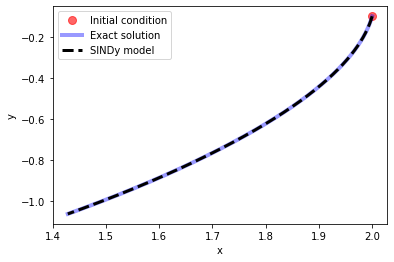

In [64]:
plt.figure()
plt.plot(x0_test[0], x0_test[1], "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test[:,0], x_test[:,1], "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Hamiltnian of the system
The Hamiltonain of a system $\dot{x}=f(x)$ is given by:
$$
	\dot{x} = f(x) - R(x)p \\
	\dot{p} = - \frac{\partial f}{\partial x}^\top + \frac{1}{1} \left( \frac{\partial p^\top R(x)p}{\partial x} \right)^\top - \left(\frac{\partial q}{\partial x} \right)^\top
$$

The Hamiltonain of the simple pendulum is given by
$$
	\begin{bmatrix} \dot{x_1} \\ \dot{x_2} \\ \dot{p_1} \\ \dot{p_2} \end{bmatrix}
	= \begin{bmatrix} x_2 \\ -x_4-sin(x_1) \\ x_3*cos(x_1)-x_1 \\ x_3-x_2 \end{bmatrix}
$$

In [65]:
def hamiltonian_pendulum(x , t):
    return [x[1], -x[3]-np.sin(x[0]), x[3]*np.cos(x[0])-x[0], -x[2]-x[1]]

## Collect Train Data

In [66]:
dt = 0.01
t_train = np.arange(0, 5, dt)
x0_train = [1, 0, 1, 0]
x_train = odeint(hamiltonian_pendulum, x0_train, t_train)
x_dot_train = np.array([hamiltonian_pendulum(xi, 1) for xi in x_train])

[Text(0.5, 0, 'x1'),
 Text(0, 0.5, 'x2'),
 Text(0.5, 1.0, 'Training data X (Hamiltonian system)')]

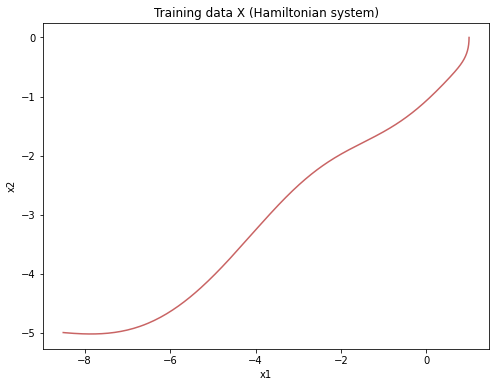

In [67]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_train[:, 0], x_train[:, 1], color="firebrick", alpha=0.7)
ax.set(xlabel="x1", ylabel="x2", title="Training data X (Hamiltonian system)")

[Text(0.5, 0, 'p1'),
 Text(0, 0.5, 'p2'),
 Text(0.5, 1.0, 'Training data P (Hamiltonian system)')]

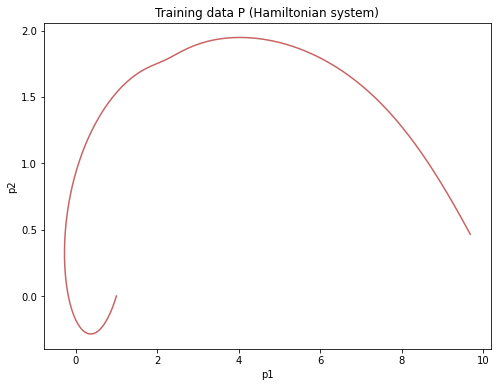

In [68]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(x_train[:, 2], x_train[:, 3], color="firebrick", alpha=0.7)
ax.set(xlabel="p1", ylabel="p2", title="Training data P (Hamiltonian system)")

## Set up SINDY

In [69]:
differentiation_method = ps.FiniteDifference(order=2)
optimizer = ps.STLSQ(threshold=0.2)

In [70]:
poly_library = ps.PolynomialLibrary(degree=1, include_bias=False)
fourier_library = ps.FourierLibrary()
combined_library = poly_library * fourier_library

In [71]:
model = ps.SINDy(feature_library=combined_library,
                 feature_names=["x1", "x2", "p1","p2"])
model.fit(x_train, t=dt)

# model.print()  # prints out long and unobvious model
print("Feature names:\n", model.get_feature_names())

Feature names:
 ['x1 sin(1 x1)', 'x1 cos(1 x1)', 'x1 sin(1 x2)', 'x1 cos(1 x2)', 'x1 sin(1 p1)', 'x1 cos(1 p1)', 'x1 sin(1 p2)', 'x1 cos(1 p2)', 'x2 sin(1 x1)', 'x2 cos(1 x1)', 'x2 sin(1 x2)', 'x2 cos(1 x2)', 'x2 sin(1 p1)', 'x2 cos(1 p1)', 'x2 sin(1 p2)', 'x2 cos(1 p2)', 'p1 sin(1 x1)', 'p1 cos(1 x1)', 'p1 sin(1 x2)', 'p1 cos(1 x2)', 'p1 sin(1 p1)', 'p1 cos(1 p1)', 'p1 sin(1 p2)', 'p1 cos(1 p2)', 'p2 sin(1 x1)', 'p2 cos(1 x1)', 'p2 sin(1 x2)', 'p2 cos(1 x2)', 'p2 sin(1 p1)', 'p2 cos(1 p1)', 'p2 sin(1 p2)', 'p2 cos(1 p2)']


In [72]:
model.print()

(x1)' = -0.122 x1 cos(1 x1) + -0.532 x1 cos(1 x2) + 0.394 x1 sin(1 p2) + 0.356 x2 cos(1 x1) + -0.275 x2 sin(1 p2) + -0.053 x2 cos(1 p2) + 0.245 p1 cos(1 x1) + -0.881 p1 sin(1 x2) + 0.111 p1 cos(1 x2) + 0.346 p1 cos(1 p2) + 0.439 p2 sin(1 x1) + 1.007 p2 sin(1 x2) + -0.176 p2 sin(1 p2)
(x2)' = -0.187 x1 cos(1 x1) + -0.542 x1 cos(1 x2) + 0.362 x2 cos(1 x1) + 0.298 x2 sin(1 p2) + -0.153 p2 cos(1 p2)
(p1)' = -0.680 x1 sin(1 x1) + -0.721 x1 sin(1 x2) + -0.366 x1 cos(1 p1) + -0.416 x1 sin(1 p2) + 0.742 x2 sin(1 x1) + 0.398 x2 cos(1 p1) + 0.154 x2 sin(1 p2) + 0.567 p1 sin(1 x2) + -0.293 p1 cos(1 x2) + -1.546 p2 sin(1 x2) + -0.199 p2 sin(1 p1) + 0.347 p2 sin(1 p2)
(p2)' = -0.461 x1 sin(1 x1) + 0.270 x1 cos(1 p1) + 0.366 x2 sin(1 x1) + 0.243 x2 sin(1 x2) + -0.306 x2 cos(1 p1) + -0.786 x2 cos(1 p2) + -0.695 p1 cos(1 p2)


## Evaluate on Test Data

In [73]:
x0_test = [2, -0.1, 2, -0.1 ]
t_test = np.linspace(0, 1, 1000)

x_test = odeint(hamiltonian_pendulum, x0_test, t_test)
sim = model.simulate(x0_test, t=t_test)

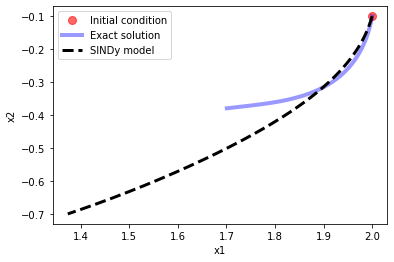

In [74]:
plt.figure()
plt.plot(x0_test[0], x0_test[1], "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test[:,0], x_test[:,1], "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

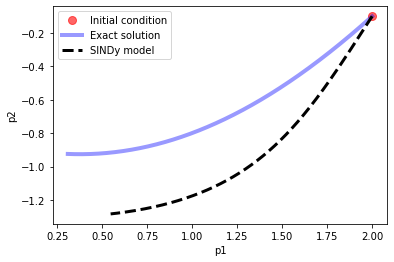

In [75]:
plt.figure()
plt.plot(x0_test[2], x0_test[3], "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test[:,2], x_test[:,3], "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 2], sim[:, 3], "k--", label="SINDy model", linewidth=3)
plt.xlabel("p1")
plt.ylabel("p2")
plt.legend()
plt.show()